In [169]:
library(data.table)
library(ggplot2)
library(ggpubr)
library(dplyr)
# library(hrbrthemes)
library(viridis)
library(scales) # to access break formatting functions
`%!in%` <- Negate(`%in%`)
theme_set(theme_bw())

In [2]:
e_coli <- fread("/mnt/hpccs01/scratch/microbiome/n10853499/02-lorikeet_testing/04-instrain_zymo/e_coli_97057.tsv")
read_names_lori <- fread("/mnt/hpccs01/scratch/microbiome/n10853499/02-lorikeet_testing/04-instrain_zymo/lori_reads.txt", header=F)
read_names_gatk <- fread("/mnt/hpccs01/scratch/microbiome/n10853499/02-lorikeet_testing/04-instrain_zymo/gatk_reads.txt", header=F)
# read_names_gatk <- read_names_gatk[V1 %like% "SRR12324251"]
# read_names

In [153]:
# instrain conani to reference
# library("bracer")?glob
# ?Sys.glob
path = "/mnt/hpccs01/scratch/microbiome/n10853499/02-lorikeet_testing/04-instrain_zymo/02-instrain_profiles/"
paths <- Sys.glob(paste0(path, "*_[123]"))

get_ani_to_reference <- function(directory_path) {
    genome_name <- strsplit(directory_path, "/")[[1]][10]
    genome_name_prefix <- gsub("_[123]", "", genome_name)
    sample_number <- gsub(paste0(genome_name_prefix, "_"), "", genome_name)
    file_path <- paste0(directory_path, "/output/", genome_name, "_genome_info.tsv")
    data <- fread(file_path)
    data$reference <- genome_name_prefix
    data$sample <- sample_number
#     print(data)
    return(data[genome == 'all_scaffolds', c("reference", "sample", "conANI_reference", "popANI_reference")])
}

print(paths[1])
instrain_reference_ani <- do.call(rbind, lapply(paths, get_ani_to_reference))
instrain_reference_ani$tool <- "instrain"

[1] "/mnt/hpccs01/scratch/microbiome/n10853499/02-lorikeet_testing/04-instrain_zymo/02-instrain_profiles/Bacillus_subtilis_complete_genome_1"


In [154]:
lori_path <- "/mnt/hpccs01/scratch/microbiome/n10853499/02-lorikeet_testing/04-instrain_zymo/01-lorikeet_zymo"
results <- Sys.glob(paste0(lori_path, "/*"))
# print(results)
lorikeet_get_ani_to_reference <- function(directory_path) {
    # print(directory_path)
    genome_name <- strsplit(directory_path, "/")[[1]][10]
    # print(genome_name)
    consensus_file_path <- paste0(directory_path, "/", genome_name, "_consensus_ani.tsv")
    con_table <- fread(consensus_file_path, skip="SampleID")
    con_m <- as.matrix(con_table[, -c("SampleID")])
    con_ani_ref <- con_m[row(con_m)==col(con_m)]
    
    population_file_path <- paste0(directory_path, "/", genome_name, "_population_ani.tsv")
    pop_table <- fread(population_file_path, skip="SampleID")
    pop_m <- as.matrix(pop_table[, -c("SampleID")])
    pop_ani_ref <- pop_m[row(pop_m)==col(pop_m)]
    
    return_table <- data.table(sample=c(1, 2, 3), conANI_reference=con_ani_ref, popANI_reference=pop_ani_ref)
    return_table$reference <- genome_name
    return(return_table)
}
# lorikeet_get_ani_to_reference(results[1])
lorikeet_reference_ani <- do.call(rbind, lapply(results, lorikeet_get_ani_to_reference))
lorikeet_reference_ani$tool <- "lorikeet"
# rbind(instrain_reference_ani, lorikeet_reference_ani)
lorikeet_reference_ani

sample,conANI_reference,popANI_reference,reference,tool
<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,0.9999733,0.9999718,Bacillus_subtilis_complete_genome,lorikeet
2,0.9999760,0.9999775,Bacillus_subtilis_complete_genome,lorikeet
3,0.9999728,0.9999743,Bacillus_subtilis_complete_genome,lorikeet
1,0.9999747,0.9999740,Enterococcus_faecalis_complete_genome,lorikeet
2,0.9999719,0.9999719,Enterococcus_faecalis_complete_genome,lorikeet
3,0.9999620,0.9999624,Enterococcus_faecalis_complete_genome,lorikeet
1,0.9998835,0.9998931,Escherichia_coli_complete_genome,lorikeet
2,0.9998845,0.9998968,Escherichia_coli_complete_genome,lorikeet
3,0.9998788,0.9998915,Escherichia_coli_complete_genome,lorikeet


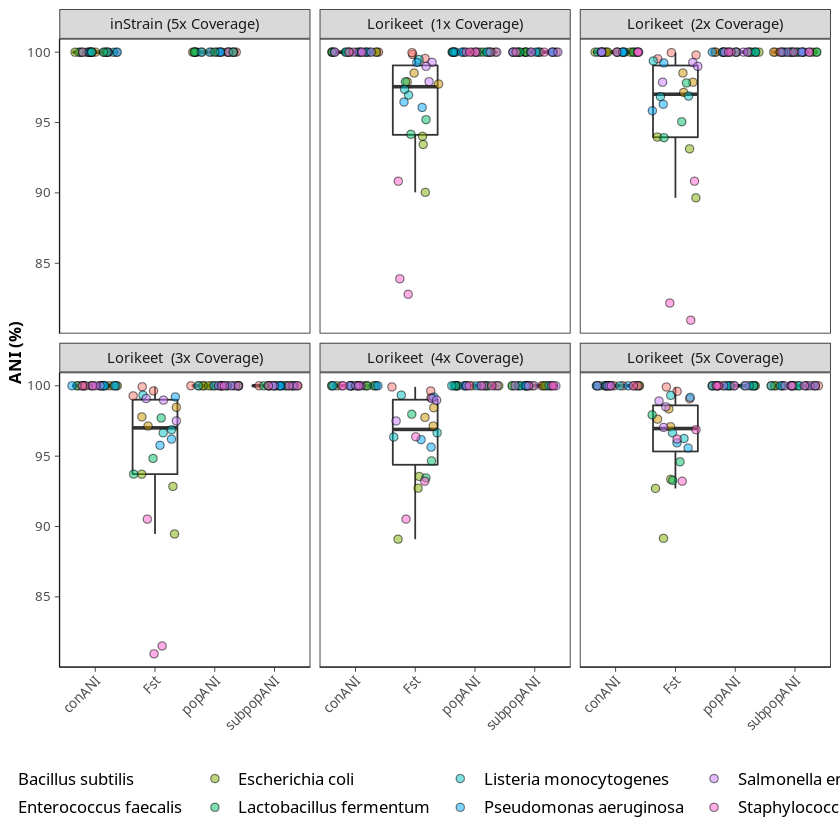

In [171]:
myColors <- hue_pal()(8)
# names(myColors) <- levels(prc$genome)
# myColors$Combined <- "#000000"

lorikeet_get_depths <- function(directory_path) {
    # print(directory_path)
    genome_name <- strsplit(directory_path, "/")[[1]][10]
    # print(genome_name)
    consensus_file_path <- paste0(directory_path, "/", genome_name, "_consensus_ani.tsv")
    con_table <- fread(consensus_file_path, skip="SampleID")
    con_m <- as.matrix(con_table[, -c("SampleID")])
    con_ani_ref <- con_m[row(con_m)!=col(con_m)][c(1, 2, 4)]
    
    population_file_path <- paste0(directory_path, "/", genome_name, "_population_ani.tsv")
    pop_table <- fread(population_file_path, skip="SampleID")
    pop_m <- as.matrix(pop_table[, -c("SampleID")])
    pop_ani_ref <- pop_m[row(pop_m)!=col(pop_m)][c(1, 2, 4)]

    sub_population_file_path <- paste0(directory_path, "/", genome_name, "_subpopulation_ani.tsv")
    sub_pop_table <- fread(sub_population_file_path, skip="SampleID")
    sub_pop_m <- as.matrix(sub_pop_table[, -c("SampleID")])
    sub_pop_ani_ref <- sub_pop_m[row(sub_pop_m)!=col(sub_pop_m)][c(1, 2, 4)]

    fst_file_path <- paste0(directory_path, "/", genome_name, "_sample_fst_values.tsv")
    fst_table <- fread(fst_file_path, skip="SampleID")
    fst_m <- as.matrix(fst_table[, -c("SampleID")])
    fst_ref <- fst_m[row(fst_m)!=col(fst_m)][c(1, 2, 4)]
    # print(sub_pop_ani_ref)
    
    return_table <- data.table(sample1=c("SRR12324251", "SRR12324251", "SRR12324252"), sample2=c("SRR12324252", "SRR12324253", "SRR12324253"), Fst=1-fst_ref, conANI=con_ani_ref, popANI=pop_ani_ref, subpopANI=sub_pop_ani_ref, run=strsplit(directory_path, "/")[[1]][9])
    return_table$reference <- genome_name
    return(return_table)
}

lori_path_depths <- "/mnt/hpccs01/scratch/microbiome/n10853499/02-lorikeet_testing/04-instrain_zymo/04.*-lorikeet_zymo*"
M1 <- rbind(do.call(rbind, lapply(lapply(Sys.glob(lori_path_depths), paste0, "/*"), Sys.glob)))
# print(M1)
lori_path_depths <- matrix(M1,dimnames=list(t(outer(colnames(M1),rownames(M1),FUN=paste)),NULL))
lorikeet_reference_ani_all_depths <- do.call(rbind, lapply(lori_path_depths, lorikeet_get_depths))
lorikeet_reference_ani_all_depths[, reference:=gsub("_complete_genome", "", reference)]
lorikeet_reference_ani_all_depths[, reference:=gsub("_", " ", reference)]
lorikeet_reference_ani_all_depths$reference <- factor(lorikeet_reference_ani_all_depths$reference)
lorikeet_ani_depths <- melt(lorikeet_reference_ani_all_depths, id.vars=c("sample1", "sample2", "run", "reference"))
instrain_ani <- ani_results[Tool=='inStrain']
instrain_ani[, Mapping:=NULL]
lorikeet_ani_depths <- full_join(lorikeet_ani_depths, instrain_ani, by=c("sample1", "sample2", "reference"="Species", "variable"="ANI Method", "value"="ANI", "run"="Tool"))
# lapply(lapply(Sys.glob(lori_path_depths), paste0, "/*"), Sys.glob)
lorikeet_ani_depths[, run:=ifelse(
    run == "04.1-lorikeet_zymo_depth_one", "Lorikeet  (1x Coverage)",
    ifelse(
        run == "04.2-lorikeet_zymo_depth_two", "Lorikeet  (2x Coverage)",
        ifelse(
            run == "04.3-lorikeet_zymo_depth_three", "Lorikeet  (3x Coverage)",
            ifelse(
                run == "04.4-lorikeet_zymo_depth_four", "Lorikeet  (4x Coverage)",
                ifelse(
                    run == "04.5-lorikeet_zymo_depth_five", "Lorikeet  (5x Coverage)",
                    "inStrain (5x Coverage)"
                )
            )
        )
    )
)]



lorikeet_ani_plots <- ggplot(data=lorikeet_ani_depths, aes(y=value*100, x=variable)) +
    geom_boxplot(outlier.shape=NA) +
#     scale_fill_viridis(discrete = TRUE, alpha=0.6) +
    geom_jitter(aes(fill=reference), size=2, pch=21, alpha=0.5, color="black") +
    scale_fill_manual(values=myColors) +
    labs(y="ANI (%)", fill=NULL) +
    theme(axis.text=element_text(size=8),
          axis.title=element_text(size=10, face="bold"),
          axis.title.y=element_text(margin = margin(t = 0, r=0, b = 0, l = 0)),
          axis.title.x=element_blank(),
          axis.line = element_line(size=0.25),
          axis.ticks=element_line(size=0.25),
          strip.text.y=element_text(size=6),
          axis.text.x=element_text(angle=45, hjust=1, vjust=1),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),
          legend.position="bottom",
          legend.direction="horizontal", 
          legend.text=element_text(size=10), 
          legend.background=element_blank(), 
          legend.key=element_blank()) +
    facet_wrap(~run)
lorikeet_ani_plots
ggsave("/home/n10853499/00-jupyter/02-lorikeet_testing/instrain_vs_lorikeet_differing_depths.png", dpi=600, width=9, height=7)

In [155]:
gatk_path <- "/mnt/hpccs01/scratch/microbiome/n10853499/02-lorikeet_testing/04-instrain_zymo/03-gatk_vcfs/"
gatk_results <- Sys.glob(paste0(gatk_path, "/*.vcf"))
gatk_get_ani_to_reference <- function(gatk_result) {
    if (grepl("combined", gatk_result)) {
        return()
    }
    gatk_result <- gsub("\\.vcf", "", gatk_result)
    genome_name <- strsplit(gatk_result, "/")[[1]][11]
    # print(genome_name)
    # genome_name <- gsub(".vcf", "", genome_name)
    gatk_con <- paste0(gatk_result, "_consensus_ani.tsv")
    gatk_pop <- paste0(gatk_result, "_population_ani.tsv")

    con_table <- fread(gatk_con, skip="SampleID")
    con_m <- as.matrix(con_table[, -c("SampleID")])
    con_ani_ref <- con_m[row(con_m)==col(con_m)]

    pop_table <- fread(gatk_pop, skip="SampleID")
    pop_m <- as.matrix(pop_table[, -c("SampleID")])
    pop_ani_ref <- pop_m[row(pop_m)==col(pop_m)]

    return_table <- data.table(sample=c(1, 2, 3), conANI_reference=con_ani_ref, popANI_reference=pop_ani_ref)
    return_table$reference <- genome_name
    return(return_table)
}

gatk_reference_ani <- do.call(rbind, lapply(gatk_results, gatk_get_ani_to_reference))
gatk_reference_ani$tool <- "gatk"

reference_ani <- rbind(instrain_reference_ani, lorikeet_reference_ani, gatk_reference_ani)
reference_ani <- melt(reference_ani, measure.vars=c("conANI_reference", "popANI_reference"))

reference_ani$tool <- factor(reference_ani$tool, levels=c("instrain", "gatk", "lorikeet"))
reference_ani[, reference:=gsub("_complete_genome", "", reference)]
reference_ani[, reference:=gsub("_", " ", reference)]
reference_ani$reference <- factor(reference_ani$reference)
# as.numeric(reference_ani$reference)
reference_ani <- as.data.table(reference_ani)
reference_ani[, paired:=ifelse(tool=="instrain", seq(1, 48, 1), ifelse(tool=="gatk", seq(49, 96, 1), seq(97, 144, 1)))]
reference_ani[, paired:=ifelse(variable=="popANI_reference" & tool != "lorikeet", paired - 24, ifelse(variable=="conANI_reference" & tool=="lorikeet", paired-24, paired))]
# reference_ani[tool=="instrain" && variable=="conANI_reference", ]
# reference_ani[tool %like% "instrain"]
# reference_ani[tool %like% "lorikeet"]
# reference_ani[tool %like% "gatk"]
reference_ani[, variable:=gsub("_reference", "", variable)]


In [9]:
lori_probs <- fread("/mnt/hpccs01/scratch/microbiome/n10853499/02-lorikeet_testing/04-instrain_zymo/lorikeet_probs.txt", header=F)
# lori_probs
lori_probs[, c("pos","b"):=tstrsplit(V4, "-")]
# lori_probs[, pos := as.numeric(V5)]
lori_probs[, V7 := as.numeric(V7)]
lori_probs[pos >= 96999 & pos <= 97999, c(pos, V7)]
gatk_probs <- fread("/mnt/hpccs01/scratch/microbiome/n10853499/02-lorikeet_testing/04-instrain_zymo/gatk_probs.txt", header=F)

[1] "96999"             "97000"             "97001"            
   [4] "97002"             "97003"             "97004"            
   [7] "97005"             "97006"             "97007"            
  [10] "97008"             "97009"             "97010"            
  [13] "97011"             "97012"             "97013"            
  [16] "97014"             "97015"             "97016"            
  [19] "97017"             "97018"             "97019"            
  [22] "97020"             "97021"             "97022"            
  [25] "97023"             "97024"             "97025"            
  [28] "97026"             "97027"             "97028"            
  [31] "97029"             "97030"             "97031"            
  [34] "97032"             "97033"             "97034"            
  [37] "97035"             "97036"             "97037"            
  [40] "97038"             "97039"             "97040"            
  [43] "97041"             "97042"             "97043"            
  [46] "97044"             "97045"             "97046"            
  [49] "97047"             "97048"             "97049"            
  [52] "97050"             "97051"             "97052"            
  [55] "97053"             "97054"             "97055"            
  [58] "97056"             "97057"             "97058"            
  [61] "97059"             "97060"             "97061"            
  [64] "97062"             "97063"             "97064"            
  [67] "97065"             "97066"             "97067"            
  [70] "97068"             "97069"             "97070"            
  [73] "97071"             "97072"             "97073"            
  [76] "97074"             "97075"             "97076"            
  [79] "97077"             "97078"             "97079"            
  [82] "97080"             "97081"             "97082"            
  [85] "97083"             "97084"             "97085"            
  [88] "97086"             "97087"             "97088"            
  [91] "97089"             "97090"             "97091"            
  [94] "97092"             "97093"             "97094"            
  [97] "97095"             "97096"             "97097"            
 [100] "97098"             "97099"             "97100"            
 [103] "97101"             "97102"             "97103"            
 [106] "97104"             "97105"             "97106"            
 [109] "97107"             "97108"             "97109"            
 [112] "97110"             "97111"             "97112"            
 [115] "97113"             "97114"             "97115"            
 [118] "97116"             "97117"             "97118"            
 [121] "97119"             "97120"             "97121"            
 [124] "97122"             "97123"             "97124"            
 [127] "97125"             "97126"             "97127"            
 [130] "97128"             "97129"             "97130"            
 [133] "97131"             "97132"             "97133"            
 [136] "97134"             "97135"             "97136"            
 [139] "97137"             "97138"             "97139"            
 [142] "97140"             "97141"             "97142"            
 [145] "97143"             "97144"             "97145"            
 [148] "97146"             "97147"             "97148"            
 [151] "97149"             "97150"             "97151"            
 [154] "97152"             "97153"             "97154"            
 [157] "97155"             "97156"             "97157"            
 [160] "97158"             "97159"             "97160"            
 [163] "97161"             "97162"             "97163"            
 [166] "97164"             "97165"             "97166"            
 [169] "97167"             "97168"             "97169"            
 [172] "97170"             "97171"             "97172"            
 [175] "97173"             "97174"             "97175"            
 [178] "97176"             "97177"             "97

In [10]:
lori_probs[pos <= 96999, c("pos", "V7"), with=FALSE]

pos,V7
<chr>,<dbl>
96999,0


In [11]:
full_probs <- data.table(cbind(lori_probs[pos >= 96999 & pos <= 97999, c("pos", "V7"), with=FALSE], gatk_probs))
# full_probs
full_probs[, V7 := round(V7)]
full_probs[, V3 := round(V3)]
full_probs[V3 != V7,]

pos,V7,V1,V2,V3
<chr>,<dbl>,<chr>,<chr>,<dbl>


# Speed benchmarks
The low depth benchmarks were performed using a set of synthetic metagenomes from Quince et al. (STRONG). The metagenomes were assembled and MAGs were binned out, one MAG was chosen as a yard stick with which to measure variant calling/profiling speed. 

The high depth benchmarks were performed using the ZymBIOMICs samples generated by Olm et al. (InStrain). The Pseudomonas auroginosa reference genome was chosen as the benchmark genomes as it had considerably higher coverage compared to the other reference genomes.

Coverage for both the low depth and high depth examples was calculated using CoverM by mapping reads to all the refernce genomes at once to minimize chances of mismappings. Unmapped reads were discarded. Since only one BAM file could be provided to inStrain at a time, the BAMs were run in series and the total processing time was summed from all three runs. The RAM usage for inStrain was then measure as the peak RAM usage from the set of three runs. We thought this was the easiest way to consistently provided inStrain with 16 cores and measure RAM usage rather than making use of other tools like GNU `parallel`.

The coverages for each genomes are as follows:

| Genome |	Sample1 Coverage	| Sample1 Coverage	| Sample1 Coverage	 | Benchmark |
| ------ | -------------------- | ----------------- | ------------------ | --------- |
| Pseudomonas_aeruginosa_complete_genome.fasta	| 345.29077	| 346.82413	| 546.3083	| High Depth |
| metabat_bins_sens.tsv.007_sub.fa	| 13.991506	| 53.069847	| 22.082962	| Low Depth |


In [46]:
# E. coli
# ecoli_depth_benchmarks <- fread("/mnt/hpccs01/scratch/microbiome/n10853499/02-lorikeet_testing/00-STRONG_sim/Synth_G45_S03D/benchmarks/complete_results.tsv")
# ecoli_depth_benchmarks <- ecoli_depth_benchmarks[Tool != "instrain_1" & Tool != "instrain_2" & Tool != "instrain_3", ]
# ecoli_depth_benchmarks_m <- melt(ecoli_depth_benchmarks)

# PSeudomonas times
pseudo_depth_benchmarks <- fread("/mnt/hpccs01/scratch/microbiome/n10853499/02-lorikeet_testing/04-instrain_zymo/benchmarks/complete_results.tsv")
pseudo_depth_benchmarks <- pseudo_depth_benchmarks[Tool != "instrain_1" & Tool != "instrain_2" & Tool != "instrain_3", ]
# pseudo_depth_benchmarks
# pseudo_depth_benchmarks[, `Wall Time`:=log10(`Wall Time`)]
# pseudo_depth_benchmarks[, `CPU Time`:=log10(`CPU Time`)]
pseudo_depth_benchmarks[, `Wall Time (min)`:=`Wall Time`/60]
pseudo_depth_benchmarks[, `CPU Time (min)`:=`CPU Time`/60]
pseudo_depth_benchmarks[, `RAM Usage (GB)`:=`RAM Usage (Gb)`]
pseudo_depth_benchmarks[, `Wall Time`:=NULL]
pseudo_depth_benchmarks[, `CPU Time`:=NULL]
pseudo_depth_benchmarks[, `RAM Usage (Gb)`:=NULL]

pseudo_depth_benchmarks_m <- melt(pseudo_depth_benchmarks)

Warning message in melt.data.table(pseudo_depth_benchmarks):
“id.vars and measure.vars are internally guessed when both are 'NULL'. All non-numeric/integer/logical type columns are considered id.vars, which in this case are columns [Tool, Genome, ...]. Consider providing at least one of 'id' or 'measure' vars in future.”
Warning message in melt.data.table(pseudo_depth_benchmarks):
“'measure.vars' [RAM Usage (Kb), Wall Time (min), CPU Time (min), RAM Usage (GB), ...] are not all of the same type. By order of hierarchy, the molten data value column will be of type 'double'. All measure variables not of type 'double' will be coerced too. Check DETAILS in ?melt.data.table for more on coercion.”


In [47]:
pseudo_depth_benchmarks_m[variable!="RAM Usage (Kb)", mean := mean(value), by=c("Tool", "Genome", "variable")]
pseudo_depth_benchmarks_m[variable!="RAM Usage (Kb)", sd := sd(value), by=c("Tool", "Genome", "variable")]
pseudo_depth_benchmarks_m[variable!="RAM Usage (Kb)", c("Tool", "Genome", "variable", "mean", "sd")] %>% unique
levels(pseudo_depth_benchmarks_m$Genome) <- c("P. aeruginosa", "E. coli")

Tool,Genome,variable,mean,sd
<chr>,<chr>,<fct>,<dbl>,<dbl>
gatk_avx,P. aeruginosa,Wall Time (min),17.2800000,0.758964938
lorikeet_avx,P. aeruginosa,Wall Time (min),4.1006000,0.046214566
instrain_total,P. aeruginosa,Wall Time (min),1022.2666667,52.539704563
gatk_avx,E. coli,Wall Time (min),118.9400000,6.041886203
lorikeet_avx,E. coli,Wall Time (min),37.5633333,0.100967542
instrain_total,E. coli,Wall Time (min),680.4700000,9.648182039
gatk_avx,P. aeruginosa,CPU Time (min),24.5644000,0.971932501
lorikeet_avx,P. aeruginosa,CPU Time (min),63.5068000,0.136005024
instrain_total,P. aeruginosa,CPU Time (min),1853.7563333,70.304514873


Tool,Wall Time (S),CPU Time (S),RAM Usage (Gb)
<chr>,<dbl>,<dbl>,<dbl>
GATK HaplotypeCaller,51121,1373395.7,12.48208
Lorikeet,17597,847768.8,16.27951


Warning message in melt.data.table(human_compute[, c("Tool", "Wall Time (min)", :
“id.vars and measure.vars are internally guessed when both are 'NULL'. All non-numeric/integer/logical type columns are considered id.vars, which in this case are columns [Tool]. Consider providing at least one of 'id' or 'measure' vars in future.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message in melt.data.table(human_compute[, c("Tool", "Wall Time (min)", :
“id.vars and measure.vars are internally guessed when both are 'NULL'. All non-numeric/integer/logical type columns are considered id.vars, which in this case are columns [Tool]. Consider providing at least one of 'id' or 'measure' vars in future.”


Tool,variable,value,Genome,sd
<chr>,<fct>,<dbl>,<chr>,<dbl>
GATK HC,Wall Time (min),852.01667,Grch38,0
Lorikeet,Wall Time (min),293.28333,Grch38,0
GATK HC,CPU Time (min),22889.92833,Grch38,0
Lorikeet,CPU Time (min),14129.47983,Grch38,0
GATK HC,RAM Usage (GB),12.48208,Grch38,0
Lorikeet,RAM Usage (GB),16.27951,Grch38,0


Tool,Genome,variable,mean,sd
<chr>,<chr>,<fct>,<dbl>,<dbl>
gatk_avx,P. aeruginosa,Wall Time (min),1.728000e+01,0.758964938
lorikeet_avx,P. aeruginosa,Wall Time (min),4.100600e+00,0.046214566
instrain_total,P. aeruginosa,Wall Time (min),1.022267e+03,52.539704563
gatk_avx,E. coli,Wall Time (min),1.189400e+02,6.041886203
lorikeet_avx,E. coli,Wall Time (min),3.756333e+01,0.100967542
instrain_total,E. coli,Wall Time (min),6.804700e+02,9.648182039
gatk_avx,P. aeruginosa,CPU Time (min),2.456440e+01,0.971932501
lorikeet_avx,P. aeruginosa,CPU Time (min),6.350680e+01,0.136005024
instrain_total,P. aeruginosa,CPU Time (min),1.853756e+03,70.304514873


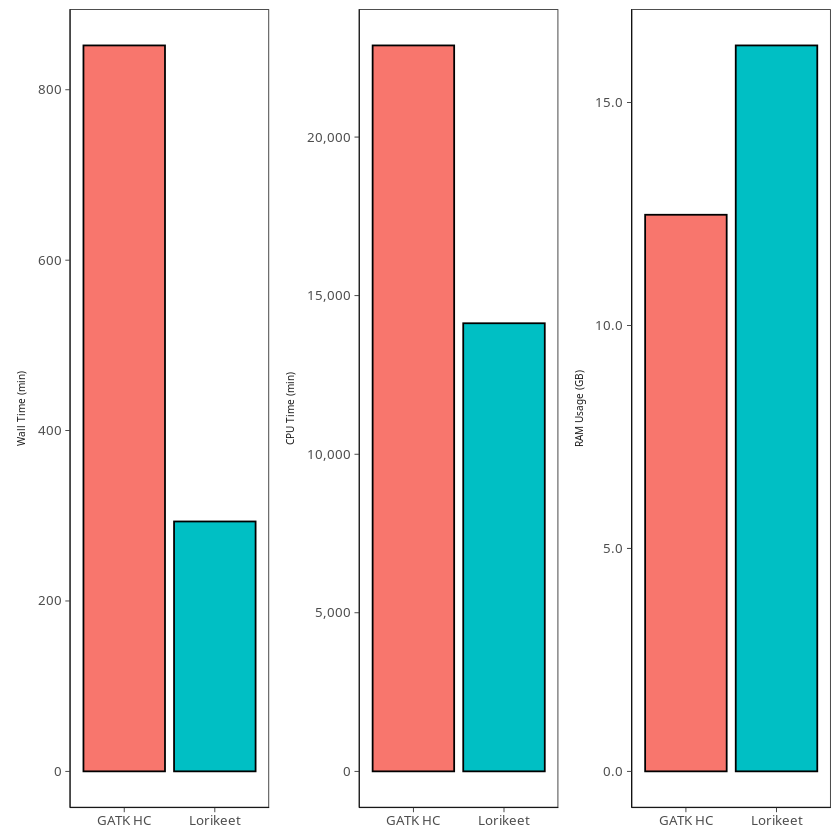

In [49]:
human_compute <- fread('/mnt/hpccs01/scratch/microbiome/n10853499/02-lorikeet_testing/06-giab/00-utah/compute_times.tsv')
human_compute[, c("Tool", "Wall Time (S)", "CPU Time (S)", "RAM Usage (Gb)"), with=TRUE]
human_compute[, `Wall Time (min)`:=`Wall Time (S)`/60]
human_compute[, `CPU Time (min)`:=`CPU Time (S)`/60]
human_compute[, `RAM Usage (GB)`:=`RAM Usage (Gb)`]
human_compute[, `Wall Time (S)`:=NULL]
human_compute[, `CPU Time (S)`:=NULL]
human_compute[, `RAM Usage (Gb)`:=NULL]

human_compute_m <- melt(human_compute[, c("Tool", "Wall Time (min)", "CPU Time (min)", "RAM Usage (GB)"), with=TRUE])
human_compute_m[, Tool:=gsub("HaplotypeCaller", "HC", Tool)]

human_times <- ggplot(data=human_compute_m) + 
    geom_bar(
        stat='identity', color="black",
        aes(x=Tool, y = value, fill=Tool)) + 
    facet_wrap(~variable, scales="free_y", nrow=1,
                strip.position = "left")  +
    scale_y_continuous(label=comma) +
    ylab(NULL) +
    xlab(NULL) +
    guides(fill=F) +
    theme(axis.text=element_text(size=8),
      axis.title=element_text(size=10, face="bold"),
      axis.title.y=element_text(margin = margin(t = 0, r=2, b = 0, l = 0)),
      axis.line = element_line(size=0.25),
      axis.ticks=element_line(size=0.25),
      strip.text.y=element_text(size=6),
      panel.grid.major = element_blank(),
      panel.grid.minor = element_blank(),
      panel.background = element_blank(),
      legend.title=element_text(margin = margin(r=30)),
      legend.text=element_text(size=10), 
      legend.background=element_blank(), 
      legend.key=element_blank(),
      strip.background = element_blank(),
      strip.placement = "outside")

human_times

for_plotting <- pseudo_depth_benchmarks_m[variable!="RAM Usage (Kb)", c("Tool", "Genome", "variable", "mean", "sd")] %>% unique
human_compute_m <- melt(human_compute[, c("Tool", "Wall Time (min)", "CPU Time (min)", "RAM Usage (GB)"), with=TRUE])
human_compute_m[, Tool:=gsub("HaplotypeCaller", "HC", Tool)]
human_compute_m$Genome <- "Grch38"
human_compute_m$sd <- 0.0
human_compute_m
human_compute_m[, Tool:=gsub("GATK HC", "gatk_avx", Tool)]
human_compute_m[, Tool:=gsub("Lorikeet", "lorikeet_avx", Tool)]
human_compute_m$mean <- human_compute_m$value
human_compute_m$value <- NULL
human_compute_m[, variable:=gsub(" \\(S\\)", "", variable)]
# human_compute_m[, variable:=gsub(" (Gb)", "", variable)]

# human_compute_m[, Genome:="Grch38"]
# human_compute_m
# for_plotting
for_plotting <- rbind(for_plotting, human_compute_m)
for_plotting
for_plotting$Tool <- factor(for_plotting$Tool, levels=c("instrain_total", "gatk_avx", "lorikeet_avx"))

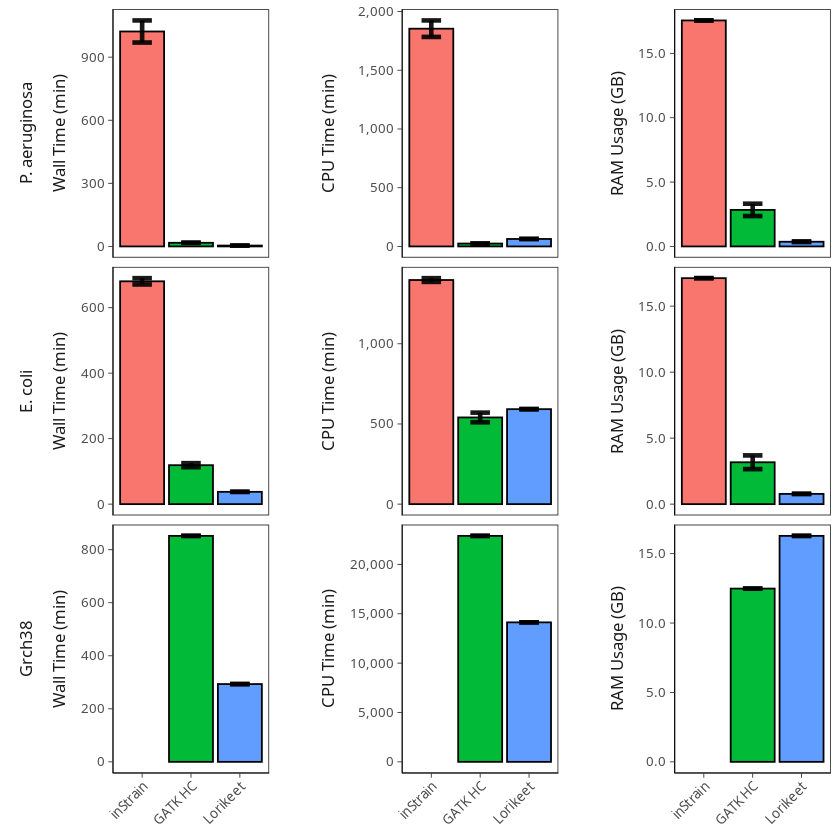

In [50]:
facet_labeller_genome <- function(variable, value) {
    c("P. aeruginosa", "", "", "E. coli", "", "", "Grch38", "", "")
}



for_plotting$Genome <- factor(for_plotting$Genome, levels=c("P. aeruginosa", "E. coli", "Grch38"))
# levels(for_plotting$Genome) <- c("P. aeruginosa", "E. coli")
pseudo <- ggplot(data=for_plotting) + 
#     geom_boxplot(aes(x=Tool, y=value), outlier.shape=NA) +
    geom_bar(stat="identity", aes(x=Tool, y=mean, fill=Tool), color="black") +
#     geom_jitter(aes(fill=Tool, x=Tool, y=value), alpha=0.5, pch=21, color="black") +
    geom_errorbar(aes(x=Tool, ymin=mean-sd, ymax=mean+sd), color="black", width=0.4, alpha=0.9, size=1.3) +
    scale_fill_discrete(labels=c("inStrain", "GATK HC", "Lorikeet"), name="Tool") +
    scale_x_discrete(labels=c("inStrain", "GATK HC", "Lorikeet")) +
    theme(axis.text=element_text(size=8),
      axis.title=element_text(size=10, face="bold"),
      axis.title.x=element_blank(),
      axis.line = element_line(size=0.25),
      axis.ticks=element_line(size=0.25),
      strip.text.y=element_text(size=10),
      axis.text.x=element_text(angle=45, hjust=1, vjust=1),
      panel.grid.major = element_blank(),
      panel.grid.minor = element_blank(),
      panel.background = element_blank(),
      legend.position="none" ,
      legend.direction="horizontal", 
      legend.text=element_text(size=10), 
      legend.background=element_blank(), 
      legend.key=element_blank(),
      strip.background = element_blank(),
      strip.placement = "outside") +
      facet_wrap(~Genome + variable, scales="free_y", ncol=3,
                strip.position = "left", 
                labeller=labeller(
                    # variable = as_labeller(c(`Wall Time` = "Wall Time (s)", `CPU Time` = "CPU Time (s)", `RAM Usage (Gb)` = "RAM Usage (Gb)")),
                    Genome = as_labeller(facet_labeller_genome)
                )
            )  +
    scale_y_continuous(label=comma) +
    ylab(NULL) +
    xlab(NULL)
pseudo
ggsave("/home/n10853499/00-jupyter/02-lorikeet_testing/compute_times.png", dpi=600, width=8, height=8)

# ZymoBIOMICs ANI Measurement Comparisons

Using the ZymoBIOMICs samples generated by Olm et al. we compare the various ANI values generated by different tools. Ideally, the ANI values between samples should be 1.00 as each tool should be finding the same variants in each sample. A tool that does not have an ANI value of 1.00 likely failed to account for certain levels of technical variance inherit in sequencing data.

Reads were mapped against all Zymo provided references (including eukaryotic genomes) and then the result BAMs were provided to inStrain and Lorikeet. The ANI values for the other tools were sourced directly from Olm et al.

In [15]:
ani_results <- fread("/mnt/hpccs01/scratch/microbiome/n10853499/02-lorikeet_testing/04-instrain_zymo/ani_result.tsv")
ani_results[, Tool:=gsub("GATK", "GATK HC", Tool)]
ani_results[, Tool:=factor(Tool, levels=c("dRep", "MIDAS", "StrainPhlan", "inStrain", "GATK HC", "Lorikeet"))]
# ani_results

In [162]:
myColors <- hue_pal()(9)
names(myColors) <- levels(prc$genome)
myColors$Combined <- "#000000"

ani_plots <- ggplot(data=ani_results[Mapping == "CoverM Make"], aes(y=ANI * 100, x=`ANI Method`)) +
    geom_boxplot(outlier.shape=NA) +
#     scale_fill_viridis(discrete = TRUE, alpha=0.6) +
    geom_jitter(aes(fill=Species), size=2, pch=21, alpha=0.5, color="black") +
    scale_fill_manual(values=myColors) +
    labs(y="ANI (%)") +
    theme(axis.text=element_text(size=8),
          axis.title=element_text(size=10, face="bold"),
          axis.title.y=element_text(margin = margin(t = 0, r=0, b = 0, l = 0)),
          axis.title.x=element_blank(),
          axis.line = element_line(size=0.25),
          axis.ticks=element_line(size=0.25),
          strip.text.y=element_text(size=6),
          axis.text.x=element_text(angle=45, hjust=1, vjust=1),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),
          legend.position="bottom",
          legend.direction="horizontal", 
          legend.text=element_text(size=10), 
          legend.background=element_blank(), 
          legend.key=element_blank()) +
    facet_wrap(~Tool)

ani_to_reference <- ggplot(data = reference_ani, aes(x=variable, y=value * 100)) +
    geom_boxplot(aes(x=variable, y=value * 100), outlier.shape=NA) +
    geom_point(aes(fill=reference), size=2, pch=21, alpha=0.5, color="black") +
    geom_line(aes(group=paired), linetype=1, alpha=0.3) + 
    scale_fill_manual(values=myColors) +
    # geom_jitter(aes(fill=reference), size=2, pch=21, alpha=0.5, color="black") +
    labs(y="ANI (%)") +
    facet_wrap(~tool, 
        labeller=labeller(
            tool = as_labeller(c(`instrain` = "inStrain", `gatk` = "GATK HC", `lorikeet` = "Lorikeet"))
        )) + 
    theme(axis.text=element_text(size=8),
          axis.title=element_text(size=10, face="bold"),
          axis.title.y=element_text(margin = margin(t = 0, r=0, b = 0, l = 0)),
          axis.title.x=element_blank(),
          axis.line = element_line(size=0.25),
          axis.ticks=element_line(size=0.25),
          strip.text.y=element_text(size=6),
          axis.text.x=element_text(angle=45, hjust=1, vjust=1),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),
          legend.position="bottom",
          legend.direction="horizontal", 
          legend.text=element_text(size=10), 
          legend.background=element_blank(), 
          legend.key=element_blank())

Warning message in myColors$Combined <- "#000000":
“Coercing LHS to a list”


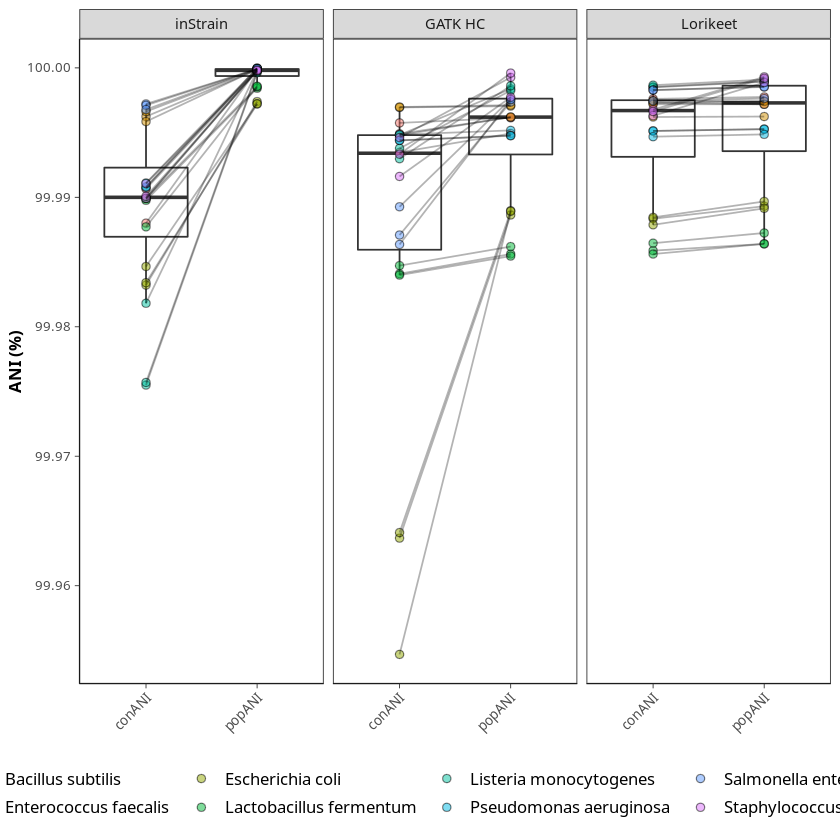

In [163]:
ani_to_reference

# Variant benchmarks

Do HaplotypeCaller and Lorikeet call all the same variants? Here we just haphazardly compare the variants called by GATK and Lorikeet.
GATK calls more variants than Lorikeet, but the variants that Lorikeet calls have very high concordance with those found by GATK. Lorikeet performs some additional filtering steps to remove potential noisy variants that GATK does not, hence the discrepancy.

In [19]:
read_file <- function(path) {
    filename <- tstrsplit(path, '/', keep=10L)
    filename <- gsub(".tsv", "", filename)
    filename <- gsub("_complete_genome_prc", "", filename)
    filename <- gsub("_prc", "", filename)
    filename <- gsub("u_vs_f", "Unused", filename)
    filename <- gsub("f_vs_f", "Filtered", filename)
    filename <- gsub("u_vs_u", "Unfiltered", filename)
    filename <- gsub("_", " ", filename)
    filtered <- tstrsplit(filename, " ", keep=3L)
    filename <- gsub(" Filtered", "", filename)
    filename <- gsub(" Unfiltered", "", filename)
    filename <- gsub(" Unused", "", filename)
    prc <- fread(path)
    prc[, c("genome", "filter"):=c(filename, filtered)]
    return(prc)
}
# Sys.glob("/lustre/scratch/microbiome/n10853499/02-lorikeet_testing/04-instrain_zymo/07-sompy_results/*.tsv")
prc_files <- Sys.glob("/mnt/hpccs01/scratch/microbiome/n10853499/02-lorikeet_testing/04-instrain_zymo/07-sompy_results/*.tsv")
prc <- lapply(prc_files, read_file)
prc <- do.call(rbind, prc)
# prc[, type:=ifelse(type=="indels", "INDELs", type)]
prc[, genome:=ifelse(genome=="combined references", "Combined", genome)]

Warning message in fread(path):
“Detected 19 column names but the data has 20 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”
Warning message in fread(path):
“Detected 19 column names but the data has 20 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”
Warning message in fread(path):
“Detected 19 column names but the data has 20 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to

Warning message in myColors$Combined <- "#000000":
“Coercing LHS to a list”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


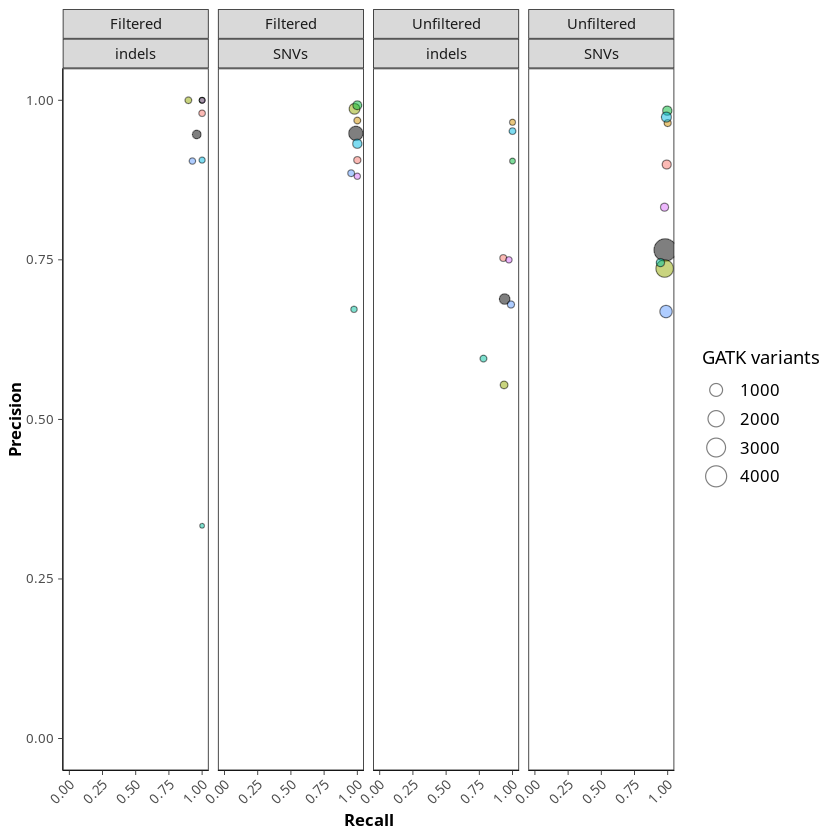

In [21]:
library(scales)

prc[, genome:=factor(genome, levels=c("Bacillus subtilis", "Enterococcus faecalis","Escherichia coli","Lactobacillus fermentum","Listeria monocytogenes","Pseudomonas aeruginosa","Salmonella enterica","Staphylococcus aureus", "Combined"))]
myColors <- hue_pal()(9)
names(myColors) <- levels(prc$genome)
myColors$Combined <- "#000000"

prc_plotting <- prc[filter=="filtered" & type!="others" & type!="records"]

zymo <- ggplot(data=prc[filter!="Unused" & type!="others" & type!="records"]) +
    geom_point(aes(x=recall, y=precision, fill=genome, size=total.truth), alpha=0.5, pch=21, color="black") +
    facet_wrap(~filter + type, nrow=1) + 
    labs(x="Recall", y="Precision", size="GATK variants", fill="Genome") +
    expand_limits(y=c(0, 1)) + 
    expand_limits(x=c(0, 1)) +
    scale_fill_manual(name="Genome", values=myColors) +
    theme(axis.text=element_text(size=8),
      axis.title=element_text(size=10, face="bold"),
      axis.title.y=element_text(margin = margin(t = 0, r=0, b = 0, l = 0)),
#       axis.title.x=element_blank(),
      axis.line = element_line(size=0.25),
      axis.ticks=element_line(size=0.25),
      strip.text.y=element_text(size=6),
      axis.text.x=element_text(angle=45, hjust=1, vjust=1),
      panel.grid.major = element_blank(),
      panel.grid.minor = element_blank(),
      panel.background = element_blank(),
#       legend.position="bottom",
#       legend.direction="horizontal", 
      legend.text=element_text(size=10), 
      legend.background=element_blank(), 
      legend.key=element_blank()) +
    guides(size = guide_legend(order = 2), colour = guide_legend(order = 1), fill=F)
zymo
# ggsave("lorikeet_vs_gatk_prc.png", height=6, width=8, dpi=600)

In [22]:
lorikeet_hg38_unfiltered <- fread('/mnt/hpccs01/scratch/microbiome/n10853499/02-lorikeet_testing/06-giab/00-utah/lorikeet_small_cut.som.py.tsv')
# lorikeet_hg38_filtered <- fread('/mnt/hpccs01/scratch/microbiome/n10853499/02-lorikeet_testing/06-giab/00-utah/lorikeet_eval_filtered.som.py.tsv')
gatk_hg38_unfiltered <- fread('/mnt/hpccs01/scratch/microbiome/n10853499/02-lorikeet_testing/06-giab/00-utah/gatk_unfiltered.som.py.tsv')
# gatk_hg38_filtered <- fread('/mnt/hpccs01/scratch/microbiome/n10853499/02-lorikeet_testing/06-giab/00-utah/gatk_filtered.som.py.tsv')
lorikeet_hg38_unfiltered[, tool:="Lorikeet"]
lorikeet_hg38_unfiltered[, genome:="hg38"]
gatk_hg38_unfiltered[, tool:="GATK HC"]
gatk_hg38_unfiltered[, genome:="hg38"]
hg38_prc <- rbind(lorikeet_hg38_unfiltered, gatk_hg38_unfiltered)

Warning message in fread("/mnt/hpccs01/scratch/microbiome/n10853499/02-lorikeet_testing/06-giab/00-utah/lorikeet_small_cut.som.py.tsv"):
“Detected 19 column names but the data has 20 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”
Warning message in fread("/mnt/hpccs01/scratch/microbiome/n10853499/02-lorikeet_testing/06-giab/00-utah/gatk_unfiltered.som.py.tsv"):
“Detected 19 column names but the data has 20 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


V1,type,total.truth,total.query,tp,fp,fn,unk,ambi,recall,⋯,recall2,precision,precision_lower,precision_upper,na,ambiguous,fp.region.size,fp.rate,tool,genome
<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int64>,<dbl>,<chr>,<chr>
0,indels,572709,804633,551836,252797,20873,0,0,0.963554,⋯,0.963554,0.685823,0.684808,0.686837,0,0,2584803627,97.801240,Lorikeet,hg38
1,SNVs,3596231,3837575,3523428,314147,72803,0,0,0.979756,⋯,0.979756,0.918139,0.917865,0.918413,0,0,2584803627,121.536119,Lorikeet,hg38
5,records,4167900,4638047,4074315,563732,93585,0,0,0.977546,⋯,0.977546,0.878455,0.878157,0.878752,0,0,2584803627,218.094711,Lorikeet,hg38
7,others,19,0,0,0,19,0,0,0.000000,⋯,0.000000,0.000000,0.000000,1.000000,NaN,NaN,2584803627,0.000000,Lorikeet,hg38
0,indels,572709,812163,552235,259928,20474,0,0,0.964251,⋯,0.964251,0.679956,0.678941,0.680970,0,0,3031042417,85.755316,GATK HC,hg38
1,SNVs,3596231,3837281,3525681,311600,70550,0,0,0.980382,⋯,0.980382,0.918797,0.918523,0.919070,0,0,3031042417,102.802916,GATK HC,hg38
5,records,4167900,4645275,4076965,568310,90935,0,0,0.978182,⋯,0.978182,0.877658,0.877360,0.877956,0,0,3031042417,187.496551,GATK HC,hg38
7,others,19,4585,0,4585,19,0,0,0.000000,⋯,0.000000,0.000000,0.000000,0.000804,0,0,3031042417,1.512681,GATK HC,hg38


In [212]:
ratios <- for_plotting[Tool=="lorikeet_avx"]
instrain_dummies <- for_plotting[Tool=="instrain_total"]

ratios$gatk_increase <- (for_plotting[Tool=="gatk_avx"]$mean / ratios$mean)
instrain_dummies$instrain_increase <- (instrain_dummies$mean / ratios[Genome!='Grch38']$mean)
ratios
instrain_dummies

Tool,Genome,variable,mean,sd,gatk_increase
<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
lorikeet_avx,P. aeruginosa,Wall Time,2.460360e+02,2.77287396,4.2140175
lorikeet_avx,E. coli,Wall Time,2.253800e+03,6.05805249,3.1663857
lorikeet_avx,P. aeruginosa,CPU Time,3.810408e+03,8.16030147,0.3867995
lorikeet_avx,E. coli,CPU Time,3.553301e+04,100.48639047,0.9127526
lorikeet_avx,P. aeruginosa,RAM Usage (Gb),3.639572e-01,0.02612138,7.7976317
lorikeet_avx,E. coli,RAM Usage (Gb),7.768463e-01,0.01660046,4.0820867
lorikeet_avx,Grch38,Wall Time,1.759700e+04,0.00000000,2.9050975
lorikeet_avx,Grch38,CPU Time,8.477688e+05,0.00000000,1.6200121
lorikeet_avx,Grch38,RAM Usage (Gb),1.627951e+01,0.00000000,0.7667353


Tool,Genome,variable,mean,sd,instrain_increase
<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
instrain_total,P. aeruginosa,Wall Time,61336.00000,3.152382e+03,249.296851
instrain_total,E. coli,Wall Time,40828.20000,5.788909e+02,18.115272
instrain_total,P. aeruginosa,CPU Time,111225.38000,4.218271e+03,29.189887
instrain_total,E. coli,CPU Time,83848.03800,6.990042e+02,2.359722
instrain_total,P. aeruginosa,RAM Usage (Gb),17.55619,1.045928e-03,48.236971
instrain_total,E. coli,RAM Usage (Gb),17.11785,1.029644e-03,22.035048


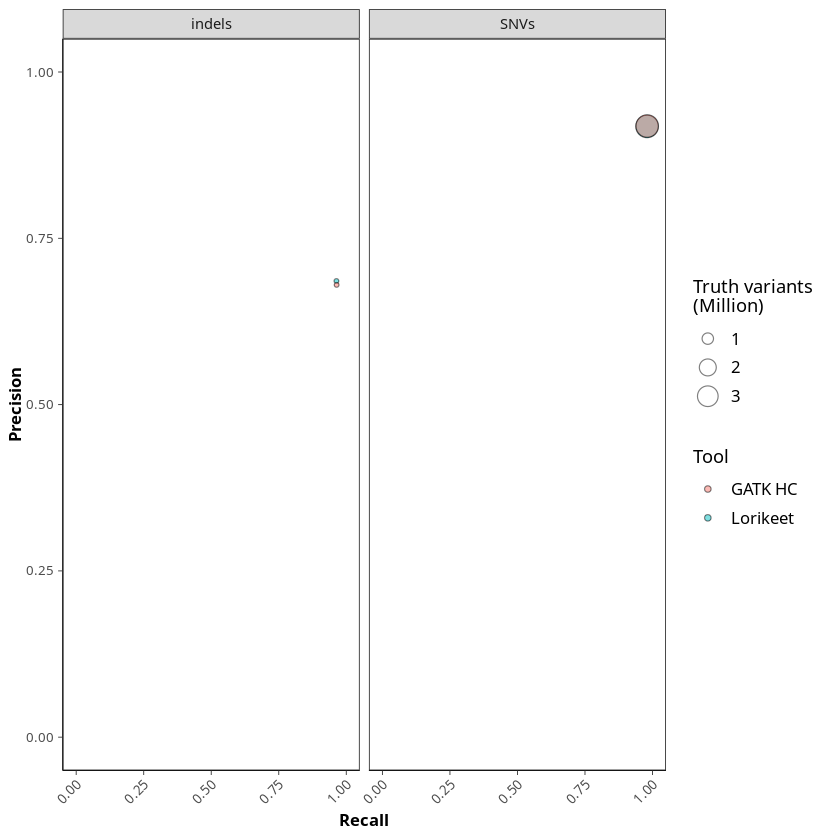

In [38]:

human <- ggplot(data=hg38_prc[type!="others" & type!="records"]) +
    geom_point(colour="black", pch=21, aes(x=recall, y=precision, fill=tool, size=total.truth / 1e6), alpha=0.5) +
    facet_wrap(~type) + 
    labs(x="Recall", y="Precision", size="Truth variants \n(Million)", fill="Tool") +
    expand_limits(y=c(0, 1)) + 
    expand_limits(x=c(0, 1)) +
    theme(axis.text=element_text(size=8),
      axis.title=element_text(size=10, face="bold"),
      axis.title.y=element_text(margin = margin(t = 0, r=0, b = 0, l = 0)),
#       axis.title.x=element_blank(),
      axis.line = element_line(size=0.25),
      axis.ticks=element_line(size=0.25),
      strip.text.y=element_text(size=6),
      axis.text.x=element_text(angle=45, hjust=1, vjust=1),
      panel.grid.major = element_blank(),
      panel.grid.minor = element_blank(),
      panel.background = element_blank(),
#       legend.position="bottom",
#       legend.direction="horizontal", 
#       legend.title=element_text(margin = margin(r=0)),
      legend.text=element_text(size=10), 
      legend.background=element_blank(), 
      legend.key=element_blank()) +
    guides(size = guide_legend(order = 2), colour = guide_legend(order = 1))
human

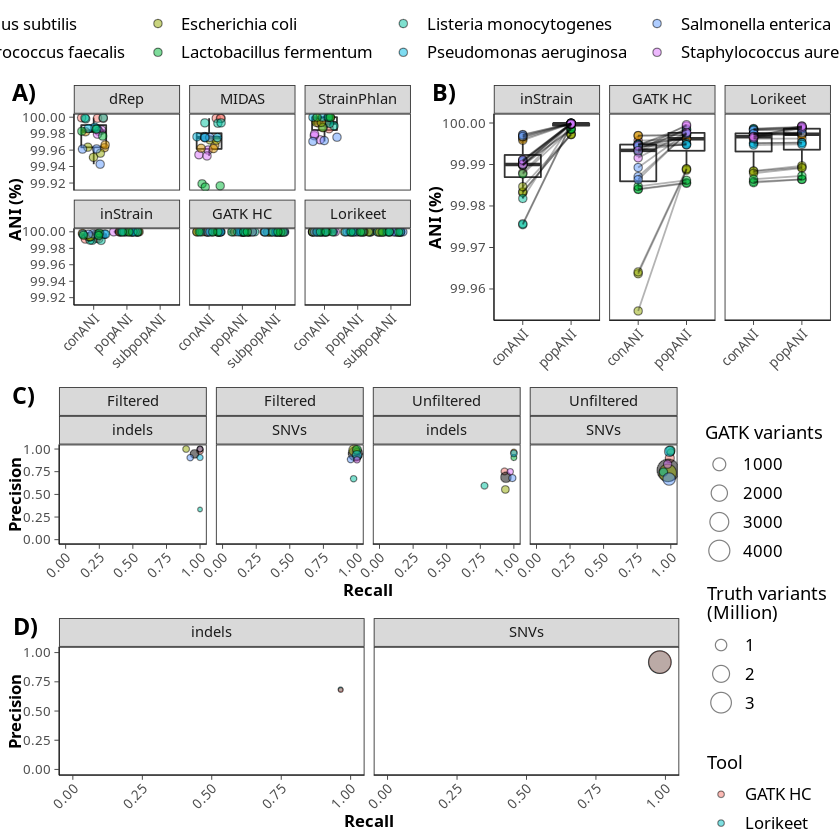

In [164]:
combined_ani <- ggarrange(ani_plots, ani_to_reference, common.legend=T, ncol=2, labels=c("A)", "B)"))
combined_prc <- ggarrange(zymo, human, nrow=2, labels=c("C)", "D)"))
ggarrange(combined_ani, combined_prc, nrow=2, heights=c(0.45, 0.55))
ggsave("/home/n10853499/00-jupyter/02-lorikeet_testing/variant_accuracy.png", dpi=600, width=10, height=10)

In [164]:
human_combo <- ggarrange(human, human_times, ncol=2, labels=c("B)", "C)"), common.legend=T, legend="bottom")

In [163]:
lorikeet_prc <- ggarrange(zymo, human_combo, nrow=2, ncol=1, labels=c("A)"), heights=c(0.5,0.5))
lorikeet_prc
ggsave("lorikeet_prc_plots.png", height=10, width=8, dpi=600, type = "cairo-png")

ERROR: Error in ggarrange(zymo, human_combo, nrow = 2, ncol = 1, labels = c("A)"), : object 'human_combo' not found


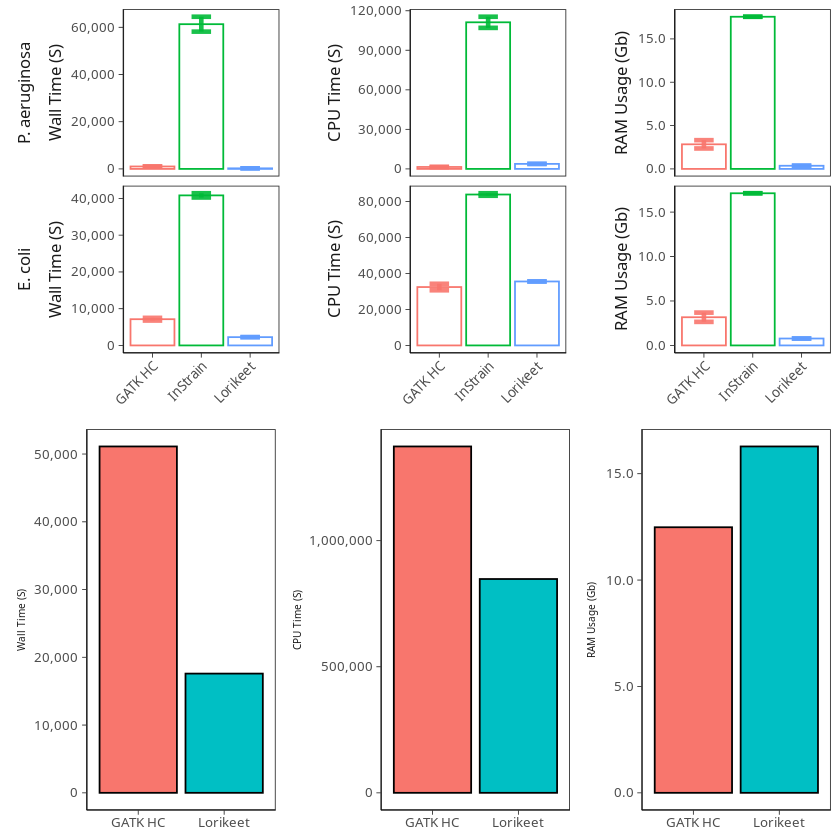

In [166]:
ggarrange(pseudo, human_times, nrow=2)

# Server Debugging


No id variables; using all as measure variables


variable,value
N008,428
N008,360
N008,370
N009,221
N009,214
N009,219


No id variables; using all as measure variables
No id variables; using all as measure variables


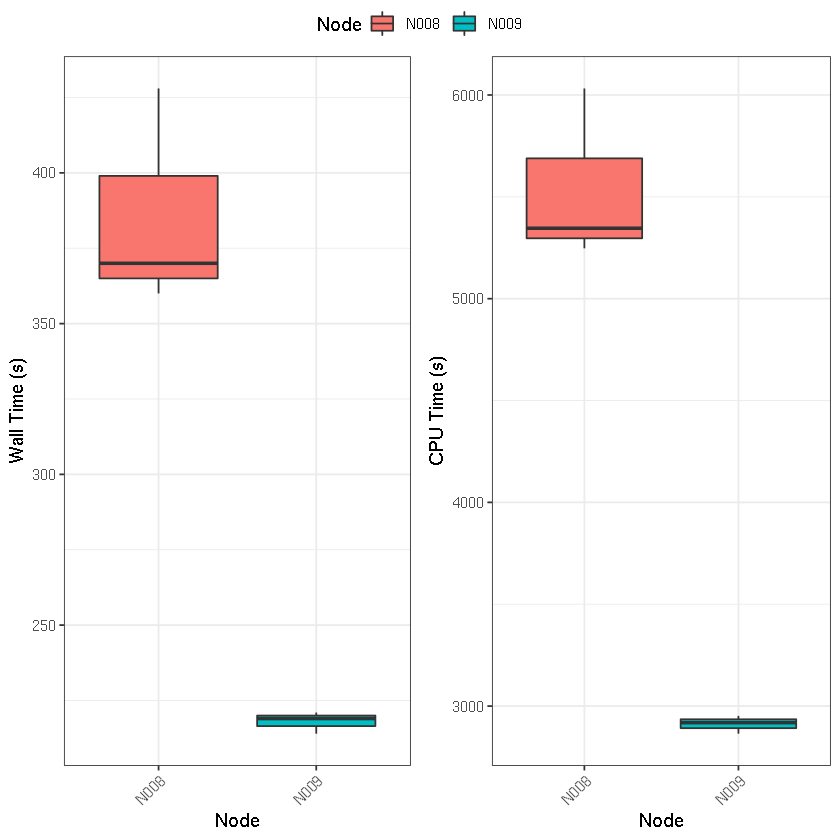

In [28]:
lorikeet_wall <- c(3 * 60 + 41, 3 * 60 + 34, 3 * 60 + 39) #, 3 * 60 + 30.9, 3 * 60 + 39.8)
lorikeet_cpu <- c(48 * 60 + 38.5, 47 * 60 + 44.7, 49 * 60 + 11.8) #, 46 * 60 + 51.9, 50 * 60 + 0.2)

node_008_wall <- c(7 * 60 + 8, 6 * 60, 6 * 60 + 10) #, 3 * 60 + 30.9, 3 * 60 + 39.8)
node_008_cpu <- c(6032.12, 5247.32, 5345.84) #, 46 * 60 + 51.9, 50 * 60 + 0.2)


wall_time = data.frame(
    N008 = node_008_wall,
    N009 = lorikeet_wall
)

cpu_time = data.frame(
    N008 = node_008_cpu,
    N009 = lorikeet_cpu
)

melt(wall_time)
wall_time_plot <- ggplot(data=melt(wall_time)) + geom_boxplot(aes(x=variable, y=value, fill=factor(variable))) +
    scale_fill_discrete(labels=c("N008", "N009"), name="Node") +
    scale_x_discrete(labels=c("N008", "N009")) +
    theme(axis.text.x = element_text(angle=45, vjust=1, hjust=1)) + 
    xlab("Node") +
    ylab("Wall Time (s)")

cpu_time_plot <- ggplot(data=melt(cpu_time)) + geom_boxplot(aes(x=variable, y=value, fill=factor(variable))) +
    scale_fill_discrete(labels=c("N008", "N009"), name="Node") +
    scale_x_discrete(labels=c("N008", "N009")) +
    theme(axis.text.x = element_text(angle=45, vjust=1, hjust=1)) + 
    xlab("Node") +
    ylab("CPU Time (s)")

ggarrange(wall_time_plot, cpu_time_plot, common.legend=T)